# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/object_detection/g3doc/installation.md) before you start.

# Imports

In [1]:
import numpy as np
import os
import sys
import tensorflow as tf

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

## Env setup

In [2]:
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [3]:
from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

In [19]:

CKPT = 'frozen_out/resnet-udacity-real-large-17675/frozen_inference_graph.pb'
PATH_TO_LABELS = 'tf_records_data/label_map.pbtxt'

NUM_CLASSES = 14

## Load a (frozen) Tensorflow model into memory.

In [20]:
detection_graph = tf.Graph()

with detection_graph.as_default():
    
  od_graph_def = tf.GraphDef()

  with tf.gfile.GFile(CKPT, 'rb') as fid:
        
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [21]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(category_index)

{1: {'id': 1, 'name': 'Green'}, 2: {'id': 2, 'name': 'Red'}, 3: {'id': 3, 'name': 'GreenLeft'}, 4: {'id': 4, 'name': 'GreenRight'}, 5: {'id': 5, 'name': 'RedLeft'}, 6: {'id': 6, 'name': 'RedRight'}, 7: {'id': 7, 'name': 'Yellow'}, 8: {'id': 8, 'name': 'off'}, 9: {'id': 9, 'name': 'RedStraight'}, 10: {'id': 10, 'name': 'GreenStraight'}, 11: {'id': 11, 'name': 'GreenStraightLeft'}, 12: {'id': 12, 'name': 'GreenStraightRight'}, 13: {'id': 13, 'name': 'RedStraightLeft'}, 14: {'id': 14, 'name': 'RedStraightRight'}}


## Helper code

In [22]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [23]:
from glob import glob

In [24]:

PATH_TO_TEST_IMAGES_DIR = 'test_images_udacity'

print(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpg'))
TEST_IMAGE_PATHS = glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpg'))
print("Length of test images:", len(TEST_IMAGE_PATHS))

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

test_images_udacity/*.jpg
Length of test images: 9


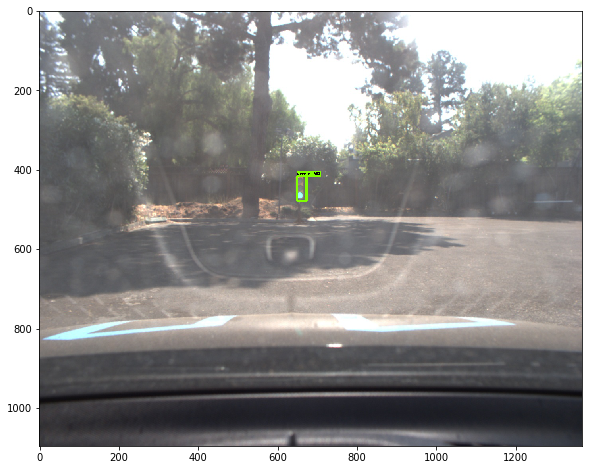

Green 0.992453
Distance (metres) 11.0
Time in milliseconds 1392.723798751831 



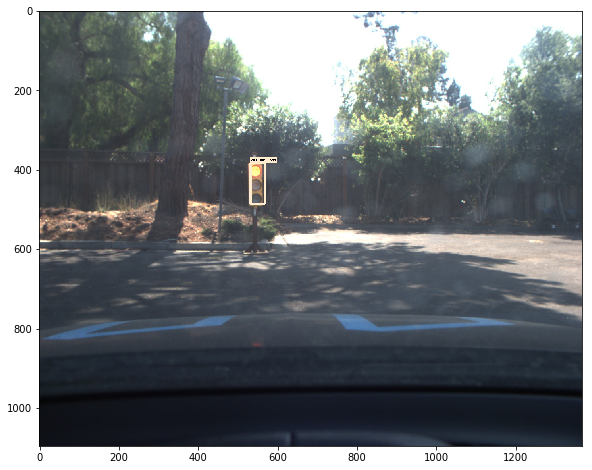

Yellow 0.554925
Distance (metres) 7.0
Time in milliseconds 88.04631233215332 



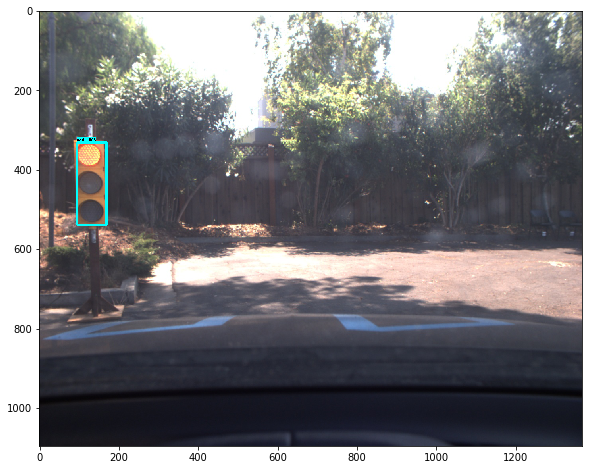

Red 0.998765
Distance (metres) 3.0
Time in milliseconds 84.4259262084961 



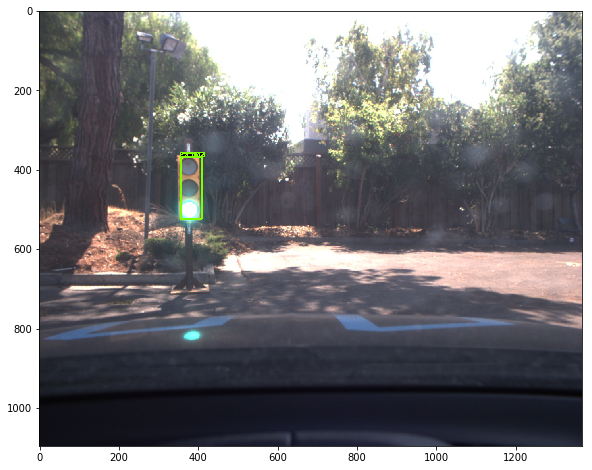

Green 0.99769
Distance (metres) 5.0
Time in milliseconds 89.09106254577637 



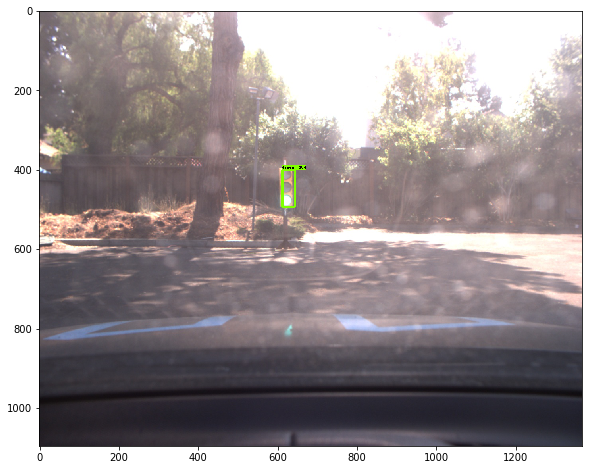

Green 0.980779
Distance (metres) 7.0
Time in milliseconds 98.75655174255371 



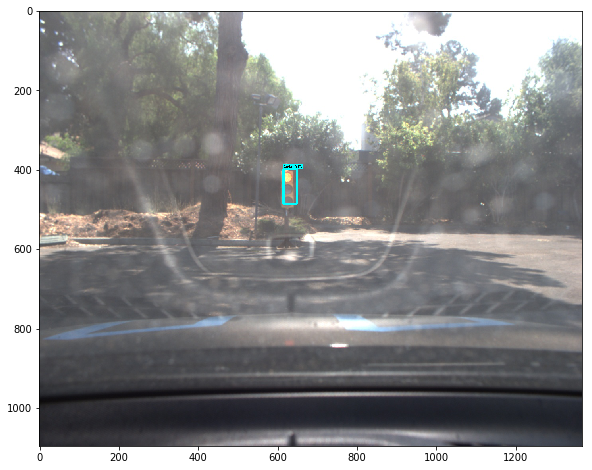

Red 0.935228
Distance (metres) 8.0
Time in milliseconds 100.25715827941895 



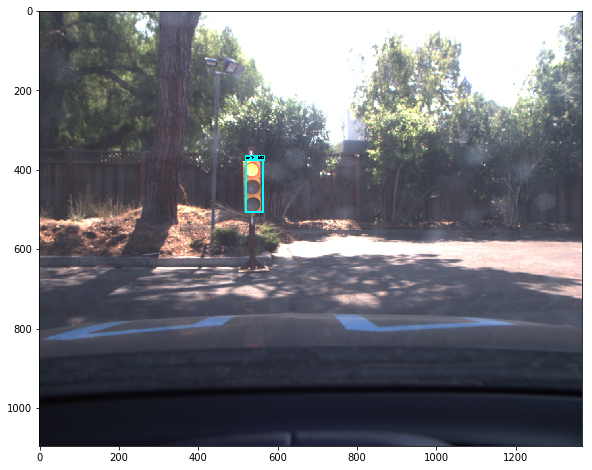

Red 0.900744
Distance (metres) 5.0
Time in milliseconds 108.05535316467285 



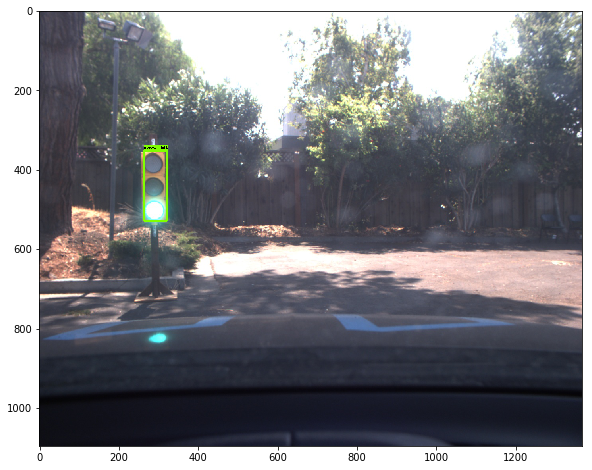

Green 0.998929
Distance (metres) 4.0
Time in milliseconds 100.81839561462402 



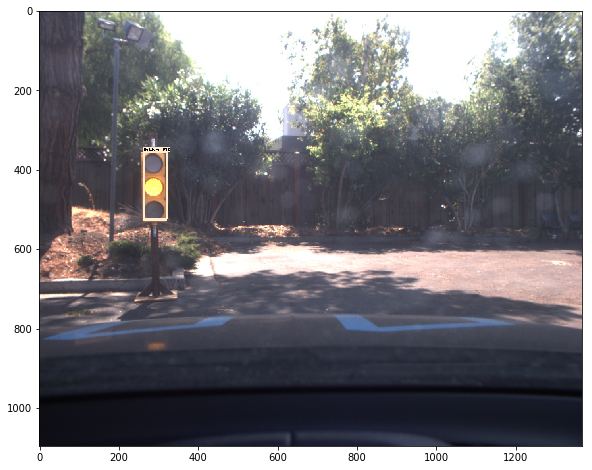

Yellow 0.999187
Distance (metres) 4.0
Time in milliseconds 104.84528541564941 



In [37]:
import time

with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        for image_path in TEST_IMAGE_PATHS:
            image = Image.open(image_path)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)

            time0 = time.time()

            # Actual detection.
            (boxes, scores, classes, num) = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})

            time1 = time.time()

            boxes = np.squeeze(boxes)
            scores = np.squeeze(scores)
            classes = np.squeeze(classes).astype(np.int32)
            
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np, boxes, classes, scores,
                category_index,
                use_normalized_coordinates=True,
                line_thickness=6)
            
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)
            plt.show()

            min_score_thresh = .50
            for i in range(boxes.shape[0]):
                if scores is None or scores[i] > min_score_thresh:

                    class_name = category_index[classes[i]]['name']
                    print('{}'.format(class_name), scores[i])
                    
                    fx =  1345.200806
                    fy =  1353.838257
                    perceived_width_x = (boxes[i][3] - boxes[i][1]) * 800
                    perceived_width_y = (boxes[i][2] - boxes[i][0]) * 600

                    # ymin, xmin, ymax, xmax = box
                    # depth_prime = (width_real * focal) / perceived_width
                    perceived_depth_x = ((.1 * fx) / perceived_width_x)
                    perceived_depth_y = ((.3 * fy) / perceived_width_y )

                    estimated_distance = round((perceived_depth_x + perceived_depth_y) / 2)
                    print("Distance (metres)", estimated_distance)
                    print("Time in milliseconds", (time1 - time0) * 1000, "\n") 

            